### Restructuring

In [5]:
from modeling.compute import Par, Var
from modeling.gen2.nesting import Model, RefNode, adda, addf

In [6]:
model = Model()
m = RefNode(name='/', ref=model)
a = Var('a')
e = Var('e')
p = Par('p', 0.1)
x = adda(m, 'x', 0.5*a)
b = adda(m, 'b', x+0.5)
d = Var('d')
c = adda(m, 'c', p*d+20+0.5*b)
adda(m, d, c-10)
addf(m, d+0.5*e, nameasidx=True);

In [7]:
eqs, eqv, dout, dins = model.data_structures()

In [8]:
from graph.operators import eqv_to_edges_tree
from graph.matrixview import render_incidence

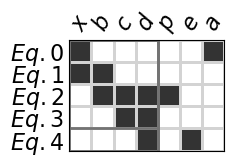

In [9]:
edges, tree, _ = eqv_to_edges_tree(eqv, output_set=dout, offset=False) 
render_incidence(edges, tree, rawvarname=True,
                 hideticks=True, figsize=(2,2), diagonalgray=False);

### Restructure by matching

In [10]:
from graph.graphview import bipartite_repr
from trash.inputresolver import mdf_order
import networkx as nx

In [11]:
B, edges_B = bipartite_repr(eqv)
M = nx.bipartite.maximum_matching(B)

In [12]:
doutM = {key:M[key] for key in dout.keys()} 
#doutM = {0: x, 1: b, 2: d, 3: c, 4: e} hard coded solution

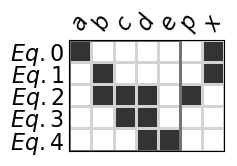

In [13]:
edges, tree, _ = eqv_to_edges_tree(eqv, output_set=doutM, offset=False) 
render_incidence(edges, tree, rawvarname=True,
                 hideticks=True, figsize=(2,2), diagonalgray=False);

In [14]:
mdf_order(eqv, dout) # should get [0, 1, (3, 2), 4]

[0, 1, (3, 2)]

### Extended tearing result

In [10]:
mdf_order(eqv, dout)

[0, 1, (3, 2), 4]

### Let's try to avoid loop

### New library

In [15]:
from presolver.tearing import min_arc_set_assign
from graph.operators import invert_edges,default_tree
from graph.graphutils import all_variables, all_edges

In [16]:
edges_for_solving = invert_edges(*edges)
eqnidxs = list(edges[0].keys())
varidxs = all_variables(*edges_for_solving)
edges_left_right = all_edges(*edges_for_solving)

In [17]:
xsol, model = min_arc_set_assign(edges_left_right, varidxs, eqnidxs)
outset_minassign = dict((right, left) for left, right in edges_left_right if xsol[left, right] > 0.5)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-13


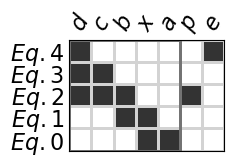

In [18]:
edges = invert_edges(eqv, newout=outset_minassign)
tree = default_tree(mdf_order(eqv, outset_minassign))
render_incidence(edges, tree, rawvarname=True,
                 hideticks=True, figsize=(2,2), diagonalgray=False);

### Old library

In [19]:
from trash.inputresolver import getallvars, invert_edges, resolve, reassign

In [20]:
vrs =getallvars(eqs)-{None}

In [21]:
sol = resolve(eqs, vrs, invert_edges(edges_B), maxiter=2, not_input=[d, b, x, c])
newdout = dict(sol[-1]['SOL'])
# possible solution newdout = {0: a, 1: x, 2: b, 3: c, 4: d}

In [22]:
newdout, dout

({0: a, 1: x, 2: b, 3: c, 4: d}, {0: x, 1: b, 2: c, 3: d, 4: None})

In [23]:
mdf_order(eqv, newdout)

[4, 3, 2, 1, 0]

In [24]:
eqsn = reassign(eqs, newdout)

In [25]:
eqsn

{0: (a, 2.0*x),
 1: (x, b - 0.5),
 2: (b, -2.0*p*d + 2.0*c - 40.0),
 3: (c, d + 10),
 4: (d, -0.5*e)}

# 2. Execution workflow 1

In [26]:
import openmdao.api as om
from modeling.gen1.notationcompute import solver, explicit, optsolver

### Execution workflow 2

In [27]:
prob = om.Problem()
model = prob.model
groups = {0:model}

## TODO
Need to exchange the numbers with the expressions probably to make the interface cleaner and independent of passing in the eqs var

In [28]:
solver(groups, eqs, 0, 1, [a], [4])
explicit(groups, eqs, 1, x, 0)
explicit(groups, eqs, 1, b, 1)
solver(groups, eqs, 1, 2, [c,d], [2,3])
optsolver(groups, {5: (None, a**2+d**2+b**2)}, 0, 1, [e], [[],[],[5]])

KeyError: 4

In [35]:
prob.setup();

In [37]:
prob.set_solver_print(level=1)
prob.driver = om.ScipyOptimizeDriver()
prob.run_driver();


group1
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 1 iterations
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 1 iterations

group1
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 0 iterations

group1
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 0 iterations
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 1 iterations

group1
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 0 iterations
+  
+  =============
+  group1.group2
+  =============
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 1 iterations
Optimization terminated successfully    (Exit mode 0)
            Current function value: [121.17674419]
            Iterations: 2
            Function eva

In [36]:
# prob.set_val('e', -21.35)
# prob.run_model()
# prob.get_val('f05')